In [1]:
%load_ext autoreload
%autoreload 2
!hostname
!pwd
import os, sys
print(sys.executable)
os.environ['CUDA_VISIBLE_DEVICES'] = "4"
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'

fish-gcp005
/home/akarshkumar0101/nca-alife/src
/home/akarshkumar0101/miniconda3/envs/nca-alife-jax/bin/python


In [2]:
import os, sys, glob, pickle
from functools import partial

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from tqdm.auto import tqdm
from einops import rearrange, reduce, repeat

In [3]:
import experiment_utils
import util

# Create Experiment

In [4]:
! rm -rf ./experiments
! mkdir -p ./experiments

In [ ]:
group.add_argument("--seed", type=int, default=0)
group.add_argument("--save_dir", type=str, default=None)

group = parser.add_argument_group("model")
group.add_argument("--n_particles", type=int, default=5000)
group.add_argument("--n_colors", type=int, default=6)
group.add_argument("--search_space", type=str, default="beta+alpha+mass+dt+half_life+rmax+c_dist+x_dist")
group.add_argument("--render_radius", type=float, default=7e-3)
group.add_argument("--rollout_steps", type=int, default=1024)

group = parser.add_argument_group("data")
group.add_argument("--n_rollout_imgs", type=int, default=4)
group.add_argument("--prompts", type=str, default="an artificial cell,a bacterium")
group.add_argument("--clip_model", type=str, default="clip-vit-base-patch32") # clip-vit-base-patch32 or clip-vit-large-patch14
group.add_argument("--coef_prompts", type=float, default=1.)
group.add_argument("--coef_novelty", type=float, default=0.)

group = parser.add_argument_group("optimization")
group.add_argument("--algo", type=str, default="Sep_CMA_ES") # Sep_CMA_ES or SimAnneal or RandomSearch
group.add_argument("--bs", type=int, default=4)
group.add_argument("--pop_size", type=int, default=16)
group.add_argument("--n_iters", type=int, default=10000)
group.add_argument("--sigma", type=float, default=1.)

In [19]:
cfg_default = dict(
    seed=0, save_dir=None,
    n_particles=5000, n_colors=6,
    search_space="beta+alpha+mass+dt+half_life+rmax+c_dist+x_dist",
    render_radius=7e-3,
    rollout_steps=1024,
    n_rollout_imgs=8,
    algo="Sep_CMA_ES",
    bs=1, pop_size=8,
    n_iters=1000,
    sigma=1.
)

seed_sweep = np.arange(1)

search_space_sweep = [
    "alpha",
    "beta+alpha",
    "beta+alpha+mass",
    "beta+alpha+mass+c_dist",
]
# n_colors_sweep = [3, 4, 6, 8]
# render_radius_sweep = [5e-3, 1e-2]
# mutate_params_sweep = [
#     'alpha',
#     'alpha+c_dist+x_dist',
#     'beta+alpha+mass',
#     'beta+alpha+mass+c_dist+x_dist',
#     'beta+alpha+mass+dt+half_life+c_dist+x_dist',
#     'beta+alpha+mass+dt+half_life+rmax+c_dist+x_dist',
# ]

prompt_sweep = [
    "a biological cell",
    "a biological cell under the microscope",
    "a bacterium",
    "bacteria under the microscope",
    "a diverse ecosystem of cells moving around",
    "top down view of a diverse colony of organisms",
    "a colorful striped snake",
    "a colorful striped caterpillar",
    "one single giant circle",
    "particles in a gas",
]

cfgs = []
for seed in seed_sweep:
    # for n_colors in n_colors_sweep:
        # for render_radius in render_radius_sweep:
    for search_space in search_space_sweep:
        for iprt, prompt in enumerate(prompt_sweep):
            cfg = cfg_default.copy()
            cfg.update(seed=seed, search_space=search_space, prompt=prompt)
            cfg.update(save_dir=f"/home/akarshkumar0101/nca-alife-data/plife_cma/{seed}_{search_space}_{iprt}")
            cfgs.append(cfg)

# print(cfgs)
print(len(cfgs))

40


In [20]:
commands = experiment_utils.create_commands(cfgs, prefix='python train_target_emergence_plife.py', out_file='./experiments/main.sh')
print('\n'.join(commands[:3]), '\n...')
print(len(commands), 'commands')

python train_target_emergence_plife.py --seed=0 --save_dir="/home/akarshkumar0101/nca-alife-data/plife_cma/0_alpha_0"                  --n_particles=5000 --n_colors=6 --search_space="alpha"                  --render_radius=0.007 --rollout_steps=1024 --n_rollout_imgs=8 --algo="Sep_CMA_ES" --bs=1 --pop_size=8 --n_iters=1000 --sigma=1.0 --prompt="a biological cell"                             
python train_target_emergence_plife.py --seed=0 --save_dir="/home/akarshkumar0101/nca-alife-data/plife_cma/0_alpha_1"                  --n_particles=5000 --n_colors=6 --search_space="alpha"                  --render_radius=0.007 --rollout_steps=1024 --n_rollout_imgs=8 --algo="Sep_CMA_ES" --bs=1 --pop_size=8 --n_iters=1000 --sigma=1.0 --prompt="a biological cell under the microscope"        
python train_target_emergence_plife.py --seed=0 --save_dir="/home/akarshkumar0101/nca-alife-data/plife_cma/0_alpha_2"                  --n_particles=5000 --n_colors=6 --search_space="alpha"                  --ren

# Visualize Results

In [21]:
import jax
import jax.numpy as jnp
import copy

In [30]:
df = []
for cfg in tqdm(cfgs):
    save_dir = cfg['save_dir']
    dfi = copy.copy(cfg)
    dfi['best_loss'] = util.load_pkl(cfg['save_dir'], "data")['best_loss'][-1]
    df.append(dfi)
df = pd.DataFrame(df)

  0%|          | 0/40 [00:00<?, ?it/s]

In [31]:
df

seed                                           save_dir  n_particles  \
0      0  /home/akarshkumar0101/nca-alife-data/plife_cma...         5000   
1      0  /home/akarshkumar0101/nca-alife-data/plife_cma...         5000   
2      0  /home/akarshkumar0101/nca-alife-data/plife_cma...         5000   
3      0  /home/akarshkumar0101/nca-alife-data/plife_cma...         5000   
4      0  /home/akarshkumar0101/nca-alife-data/plife_cma...         5000   
5      0  /home/akarshkumar0101/nca-alife-data/plife_cma...         5000   
6      0  /home/akarshkumar0101/nca-alife-data/plife_cma...         5000   
7      0  /home/akarshkumar0101/nca-alife-data/plife_cma...         5000   
8      0  /home/akarshkumar0101/nca-alife-data/plife_cma...         5000   
9      0  /home/akarshkumar0101/nca-alife-data/plife_cma...         5000   
10     0  /home/akarshkumar0101/nca-alife-data/plife_cma...         5000   
11     0  /home/akarshkumar0101/nca-alife-data/plife_cma...         5000   
12     0  /home/akarshkumar0101/nca-alife-data/plife_cma...         5000   
13     0  /home/akarshkumar0101/nca-alife-data/plife_cma...         5000   
14     0  /home/akarshkumar0101/nca-alife-data/plife_cma...         5000   
15     0  /home/akarshkumar0101/nca-alife-data/plife_cma...         5000   
16     0  /home/akarshkumar0101/nca-alife-data/plife_cma...         5000   
17     0  /home/akarshkumar0101/nca-alife-data/plife_cma...         5000   
18     0  /home/akarshkumar0101/nca-alife-data/plife_cma...         5000   
19     0  /home/akarshkumar0101/nca-alife-data/plife_cma...         5000   
20     0  /home/akarshkumar0101/nca-alife-data/plife_cma...         5000   
21     0  /home/akarshkumar0101/nca-alife-data/plife_cma...         5000   
22     0  /home/akarshkumar0101/nca-alife-data/plife_cma...         5000   
23     0  /home/akarshkumar0101/nca-alife-data/plife_cma...         5000   
24     0  /home/akarshkumar0101/nca-alife-data/plife_cma...         5000   
25     0  /home/akarshkumar0101/nca-alife-data/plife_cma...         5000   
26     0  /home/akarshkumar0101/nca-alife-data/plife_cma...         5000   
27     0  /home/akarshkumar0101/nca-alife-data/plife_cma...         5000   
28     0  /home/akarshkumar0101/nca-alife-data/plife_cma...         5000   
29     0  /home/akarshkumar0101/nca-alife-data/plife_cma...         5000   
30     0  /home/akarshkumar0101/nca-alife-data/plife_cma...         5000   
31     0  /home/akarshkumar0101/nca-alife-data/plife_cma...         5000   
32     0  /home/akarshkumar0101/nca-alife-data/plife_cma...         5000   
33     0  /home/akarshkumar0101/nca-alife-data/plife_cma...         5000   
34     0  /home/akarshkumar0101/nca-alife-data/plife_cma...         5000   
35     0  /home/akarshkumar0101/nca-alife-data/plife_cma...         5000   
36     0  /home/akarshkumar0101/nca-alife-data/plife_cma...         5000   
37     0  /home/akarshkumar0101/nca-alife-data/plife_cma...         5000   
38     0  /home/akarshkumar0101/nca-alife-data/plife_cma...         5000   
39     0  /home/akarshkumar0101/nca-alife-data/plife_cma...         5000   

    n_colors            search_space  render_radius  rollout_steps  \
0          6                   alpha          0.007           1024   
1          6                   alpha          0.007           1024   
2          6                   alpha          0.007           1024   
3          6                   alpha          0.007           1024   
4          6                   alpha          0.007           1024   
5          6                   alpha          0.007           1024   
6          6                   alpha          0.007           1024   
7          6                   alpha          0.007           1024   
8          6                   alpha          0.007           1024   
9          6                   alpha          0.007           1024   
10         6              beta+alpha          0.007           1024   
11         6              beta+alpha          0

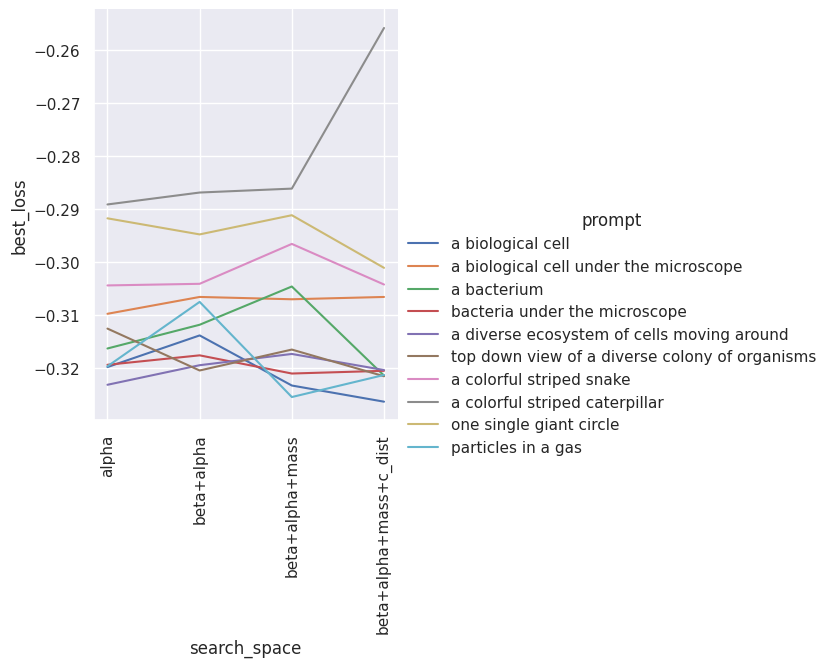

In [40]:
sns.relplot(data=df, x="search_space", y="best_loss", hue="prompt", kind="line")
plt.xticks(rotation=90);

  0%|          | 0/4 [00:00<?, ?it/s]

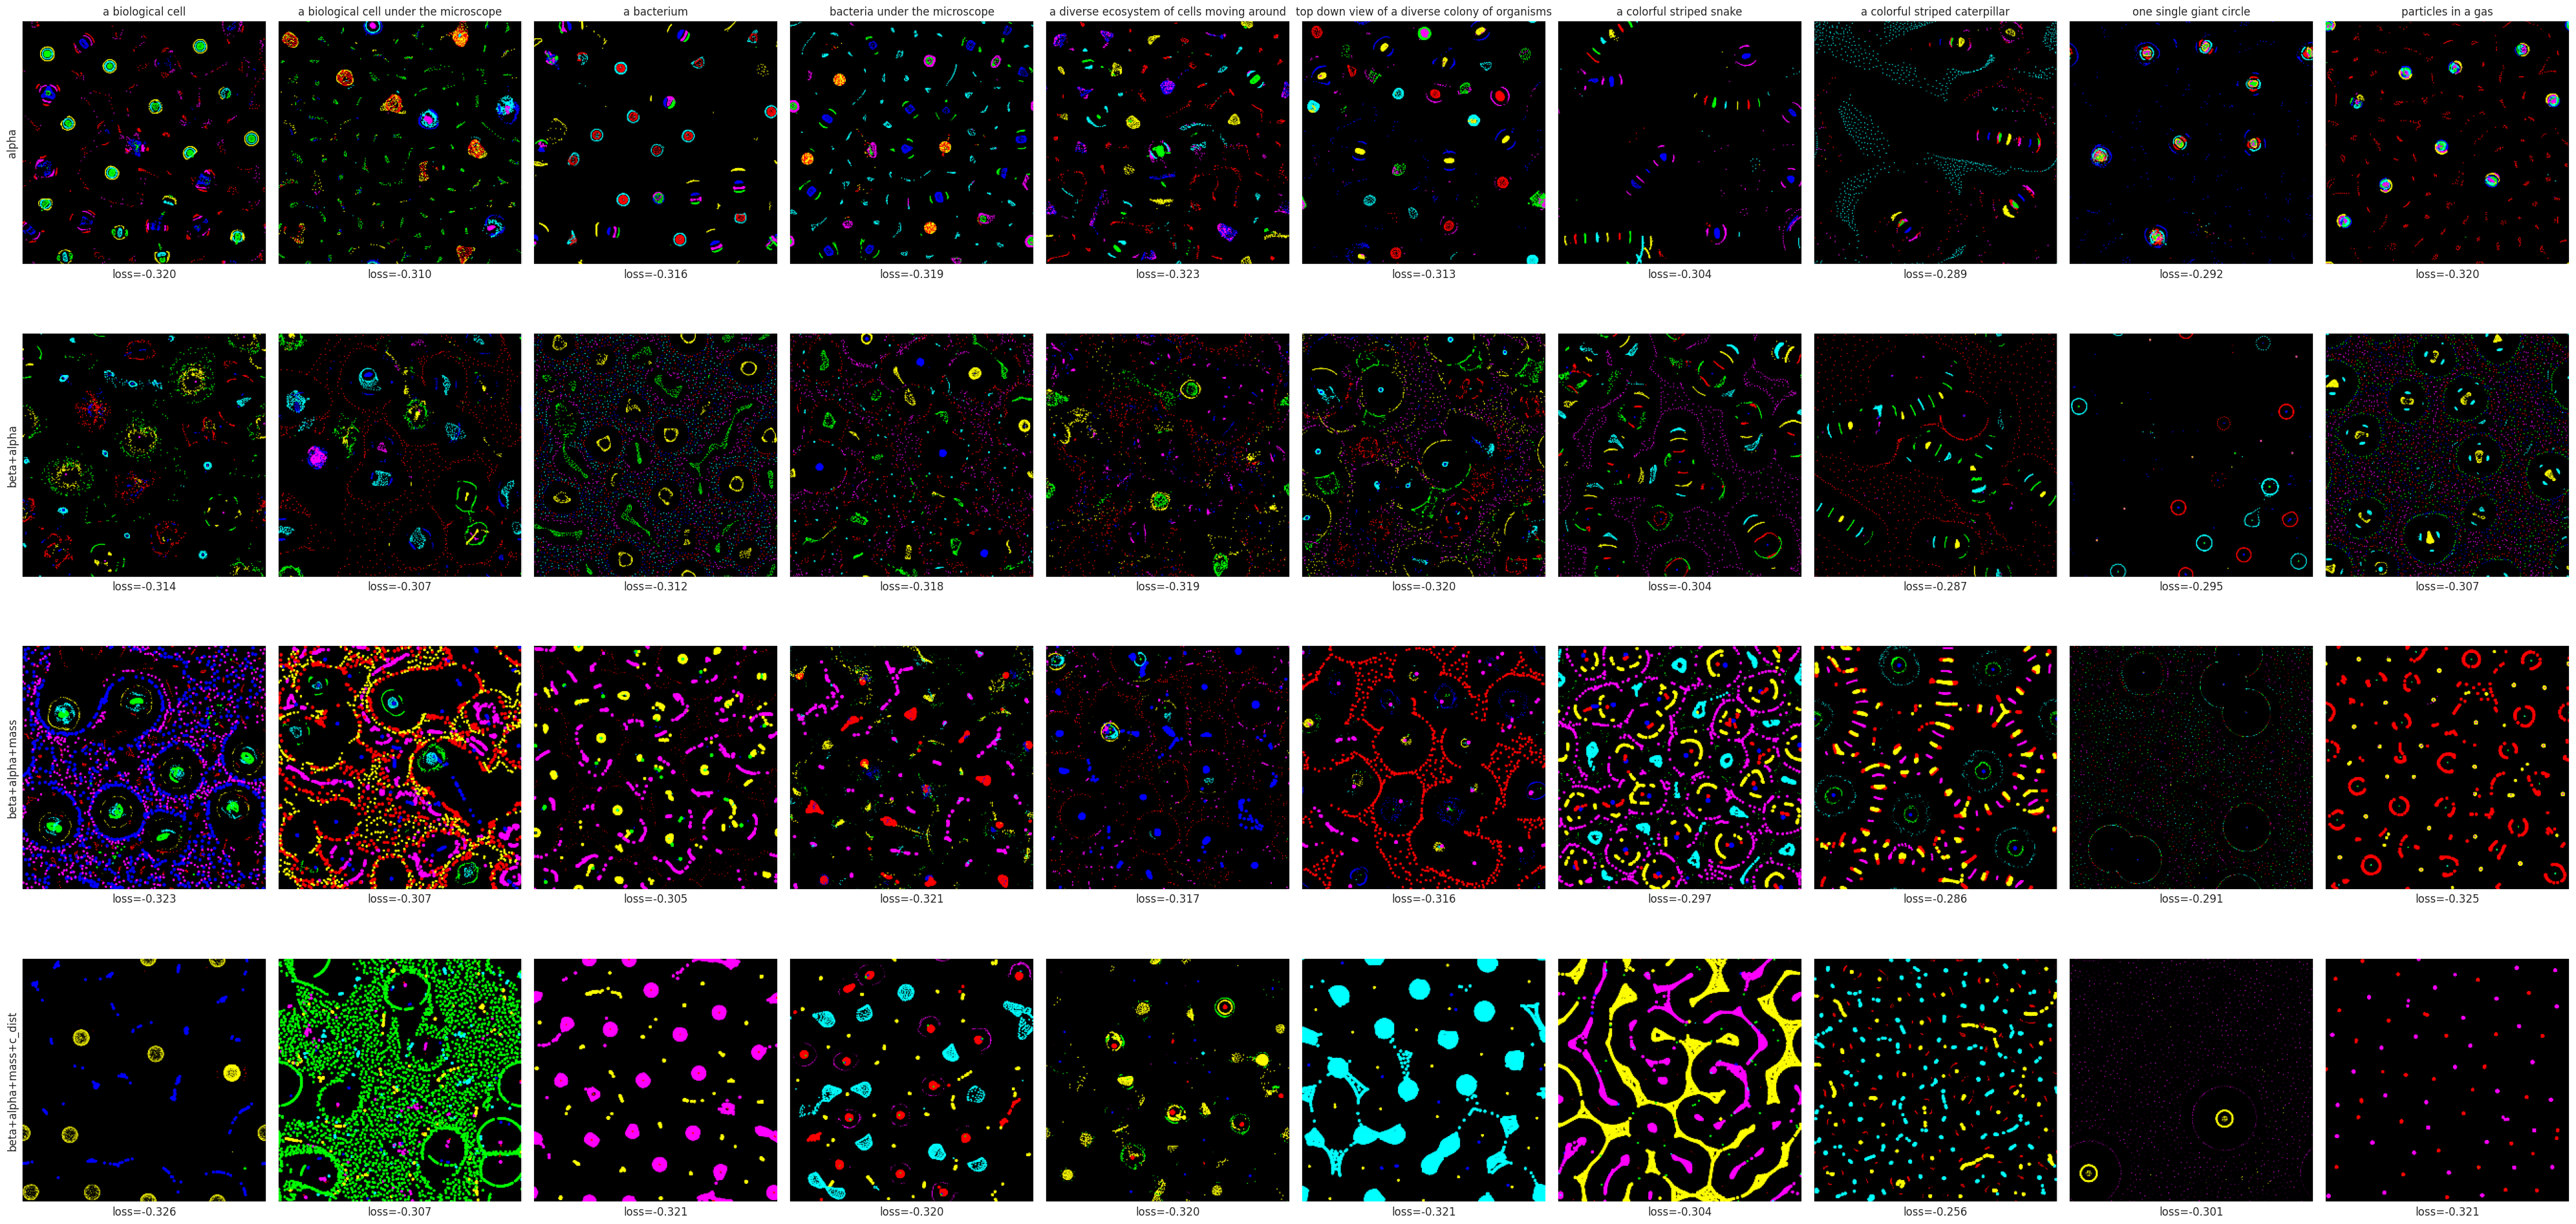

In [62]:
plt.figure(figsize=(40, 20))
iplt = 0

seed = 0
for i1, search_space in enumerate(tqdm(search_space_sweep)):
    for iprt, prompt in enumerate(prompt_sweep):
        save_dir=f"/home/akarshkumar0101/nca-alife-data/plife_cma/{seed}_{search_space}_{iprt}"

        iplt += 1
        plt.subplot(4, 10, iplt)
        img = util.load_pkl(save_dir, 'vid').astype(np.uint8)[1023]
        plt.imshow(img)
        plt.grid(False); plt.xticks([]); plt.yticks([])

        best_loss = util.load_pkl(save_dir, "data")['best_loss'][-1]
        plt.xlabel(f"loss={best_loss:.3f}")
        if i1==0:
            plt.title(prompt)
        if iprt==0:
            plt.ylabel(search_space)

plt.tight_layout()
plt.show()

  0%|          | 0/4 [00:00<?, ?it/s]

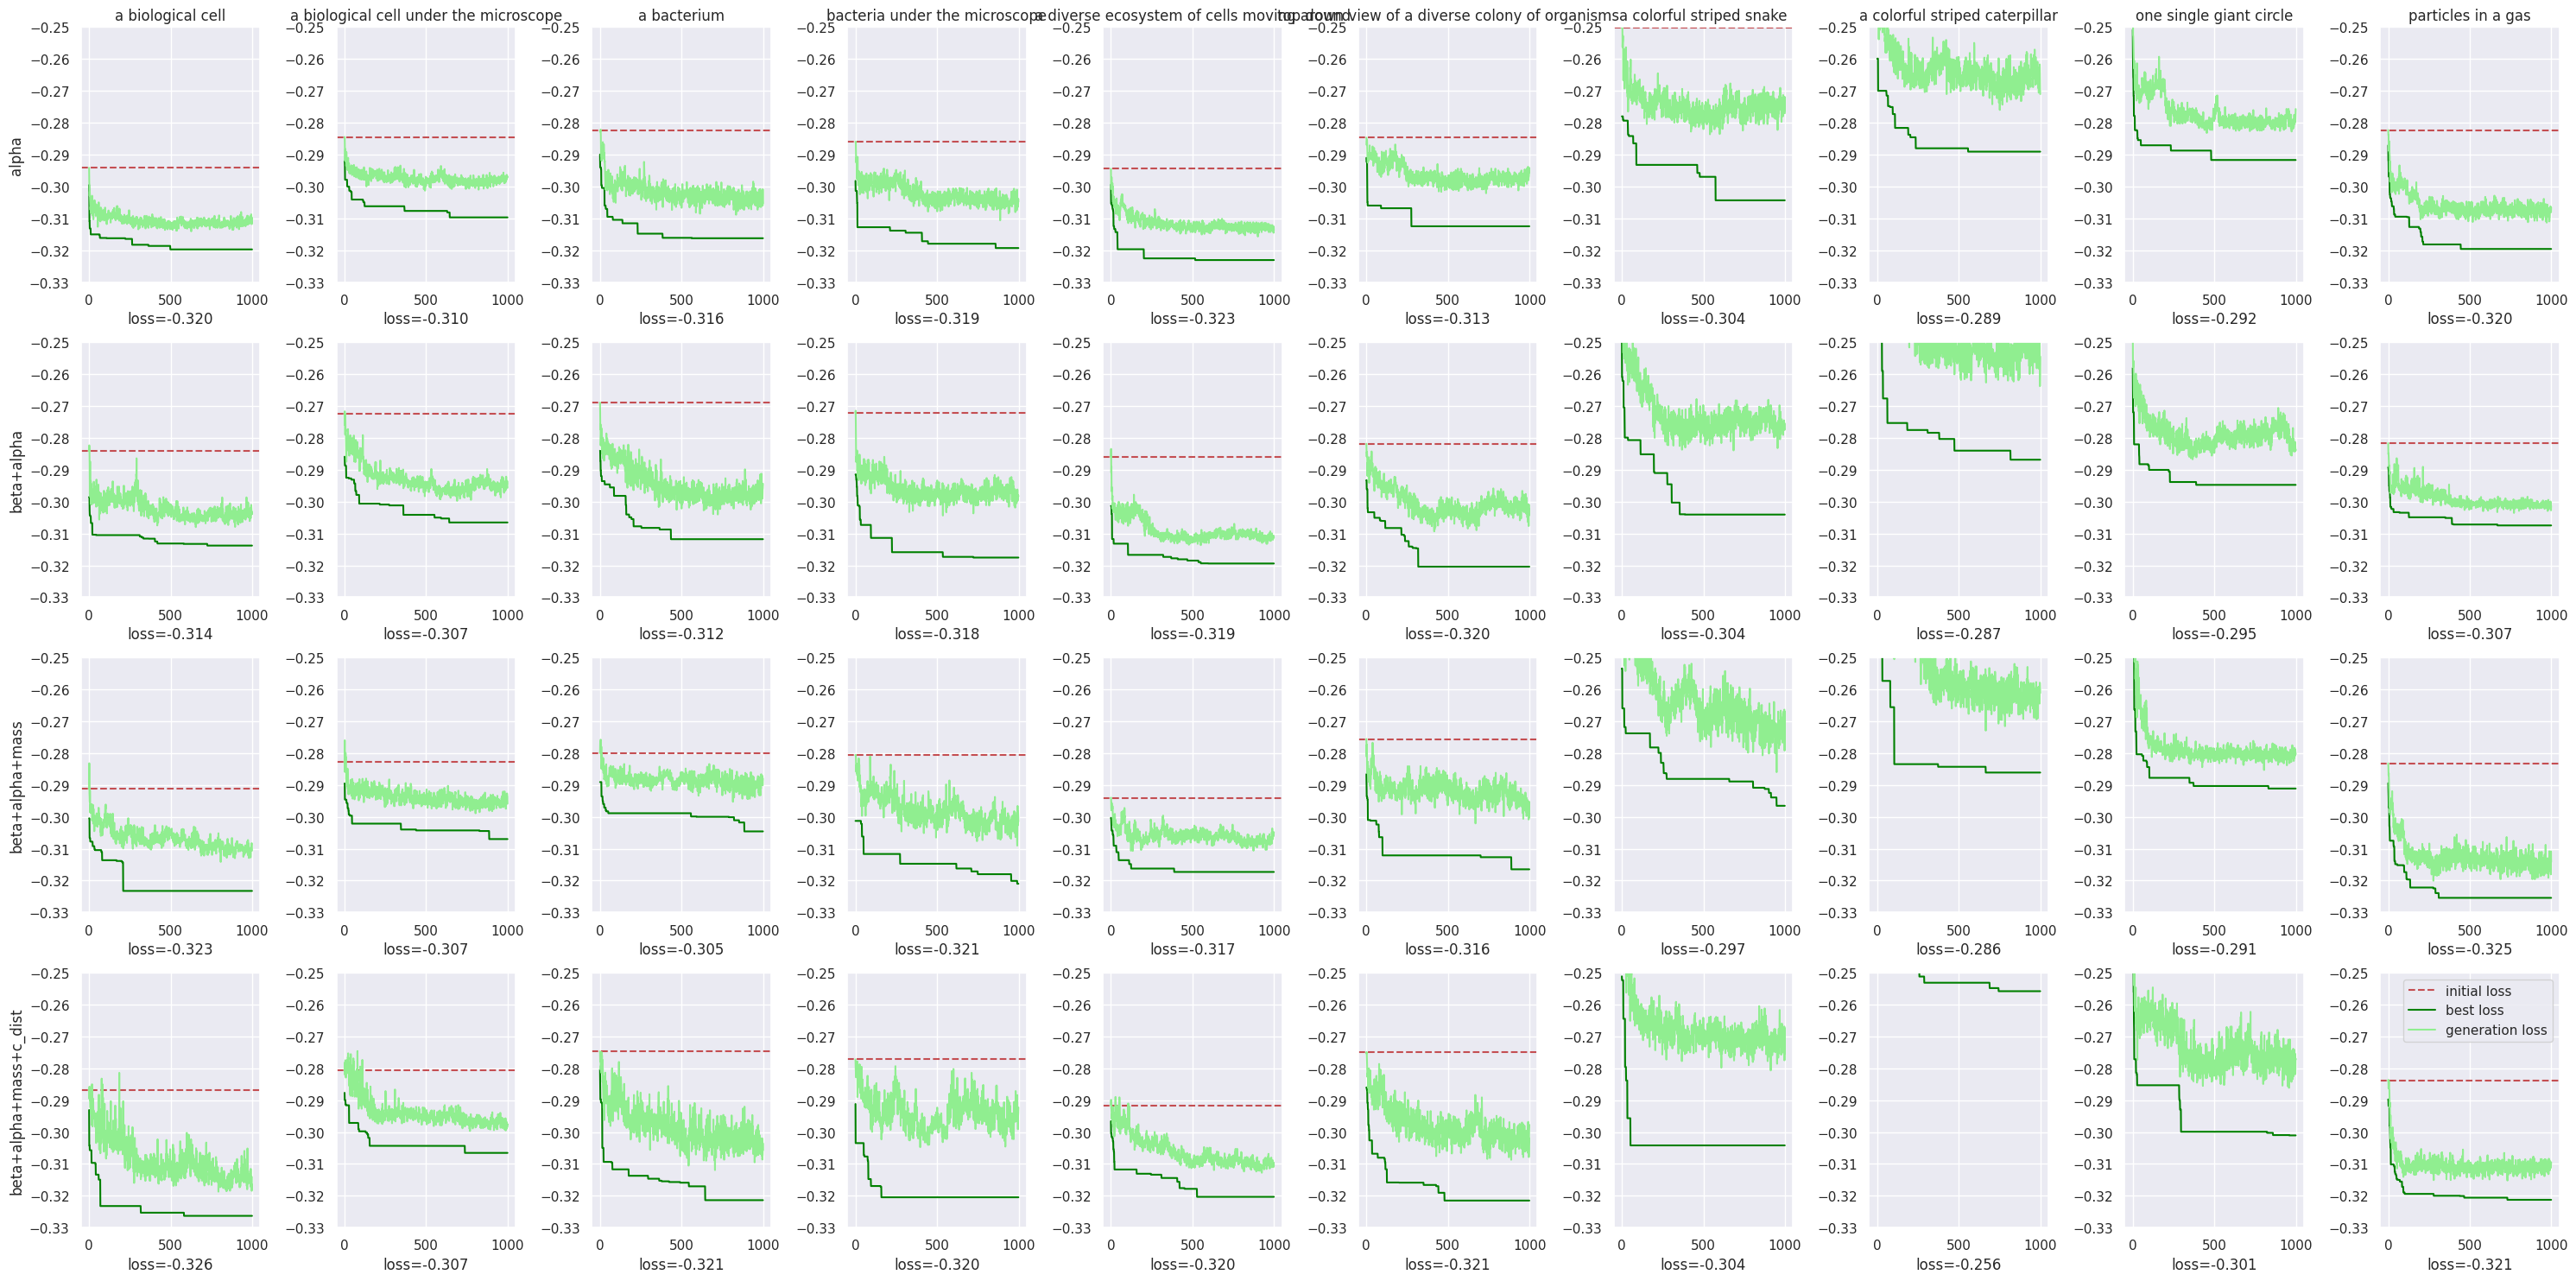

In [102]:
plt.figure(figsize=(30, 15))
iplt = 0

seed = 0
for i1, search_space in enumerate(tqdm(search_space_sweep)):
    for iprt, prompt in enumerate(prompt_sweep):
        save_dir=f"/home/akarshkumar0101/nca-alife-data/plife_cma/{seed}_{search_space}_{iprt}"

        iplt += 1
        plt.subplot(4, 10, iplt)
        data = util.load_pkl(save_dir, "data")
        plt.axhline(data['generation_loss'][0], color='r', linestyle='dashed', label='initial loss')
        plt.plot(data['best_loss'], color='green', label='best loss')
        plt.plot(data['generation_loss'], color='lightgreen', label='generation loss')
        
        # plt.grid(False); plt.xticks([]); plt.yticks([])
        plt.ylim(-.33, -.25)

        best_loss = util.load_pkl(save_dir, "data")['best_loss'][-1]
        plt.xlabel(f"loss={best_loss:.3f}")
        if i1==0:
            plt.title(prompt)
        if iprt==0:
            plt.ylabel(search_space)

plt.legend()
plt.tight_layout()
plt.show()

In [70]:
vids = []
for i1, search_space in enumerate(tqdm(search_space_sweep)):
    for iprt, prompt in enumerate(prompt_sweep):
        save_dir=f"/home/akarshkumar0101/nca-alife-data/plife_cma/{seed}_{search_space}_{iprt}"
        vid = util.load_pkl(save_dir, 'vid').astype(np.uint8)
        vid = vid[:, ::2, ::2, :]
        vids.append(vid)
vids = np.stack(vids)

  0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
vids = rearrange(vids, "(R C) T H W D -> T (R H) (C W) D", R=4)

In [78]:
vids.shape

(1536, 512, 1280, 3)

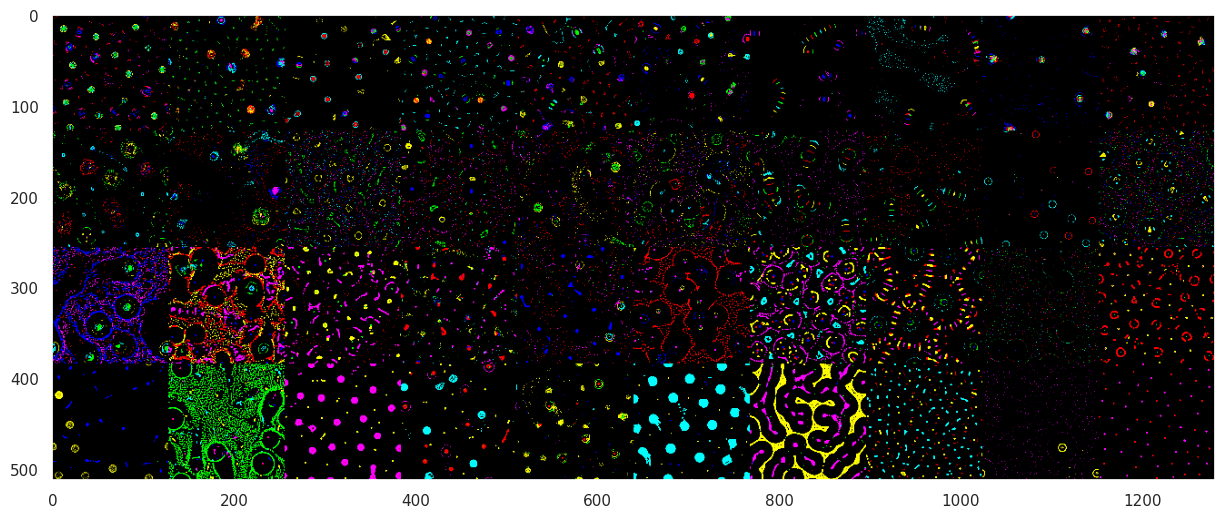

In [85]:
# plt.figure(figsize=(20, 20))
plt.imshow(vids[-1])
plt.grid(False)

In [86]:
vids.shape

(1536, 512, 1280, 3)

In [ ]:
import imageio

In [88]:
imageio.mimwrite(f'./temp/plife_large.gif', vids, fps=50)